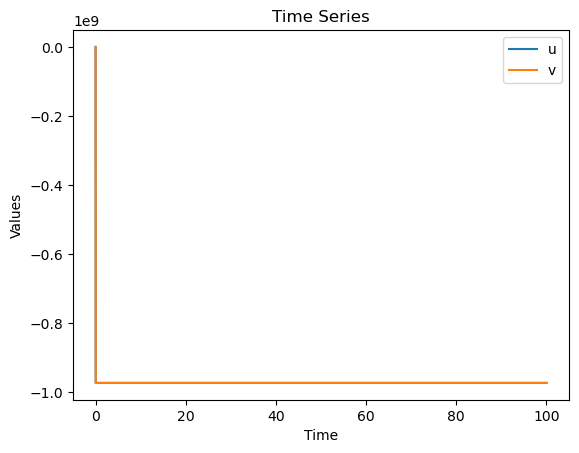

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange

t_start = 0
t_end = 100
n = 10000  # 分割数
alpha = 0.5
beta = 0.3
gamma = 0.2
delta = 0.4
u_0 = 100
v_0 = 100
dt = (t_end - t_start) / n

@njit()
def f(s, t, u_n, v_n, alpha, beta, dt):
    if np.abs(t - v_n) > 1e-10:
        return -s + u_n - (beta * dt * (np.exp(t) - np.exp(v_n)) / (t - v_n)) + alpha * dt
    else:
        return -s + u_n - beta * dt * np.exp(t) + alpha * dt

@njit()
def g(s, t, u_n, v_n, gamma, delta, dt):
    if np.abs(s - u_n) > 1e-10:
        return -t + v_n + (gamma * dt * (np.exp(s) - np.exp(u_n)) / (s - u_n)) - delta * dt
    else:
        return -t + v_n + gamma * dt * np.exp(s) - delta * dt

@njit()
def culc_jacobian(s, t, u_n, v_n, beta, gamma, dt):
    jacobian = np.zeros((2, 2), dtype=np.float64)
    jacobian[0][0] = -1
    jacobian[1][1] = -1

    if np.abs(t - v_n) > 1e-10:
        jacobian[0][1] = -beta * dt * (np.exp(t) * (t - v_n) - (np.exp(t) - np.exp(v_n))) / ((t - v_n) ** 2)
    else:
        jacobian[0][1] = -beta * dt * np.exp(t)

    if np.abs(s - u_n) > 1e-10:
        jacobian[1][0] = gamma * dt * (np.exp(s) * (s - u_n) - (np.exp(s) - np.exp(u_n))) / ((s - u_n) ** 2)
    else:
        jacobian[1][0] = gamma * dt * np.exp(s)

    return jacobian

@njit()
def invert_matrix(mat):
    det = mat[0, 0] * mat[1, 1] - mat[0, 1] * mat[1, 0]
    if np.abs(det) < 1e-10:
        raise ValueError("Singular matrix")
    inv_mat = np.zeros_like(mat)
    inv_mat[0, 0] = mat[1, 1]
    inv_mat[1, 1] = mat[0, 0]
    inv_mat[0, 1] = -mat[0, 1]
    inv_mat[1, 0] = -mat[1, 0]
    return inv_mat / det

@njit()
def culc_oed(n, alpha, beta, gamma, delta, u_0, v_0, dt):
    u = np.zeros(n + 1, dtype=np.float64)
    v = np.zeros(n + 1, dtype=np.float64)
    u[0], v[0] = u_0, v_0

    for i in prange(n):
        x, y = u[i], v[i]
        for j in range(30):
            jacobian = culc_jacobian(x, y, u[i], v[i], beta, gamma, dt)
            jacobian_inv = invert_matrix(jacobian)  # 自作の関数で逆行列を計算
            f_val = f(x, y, u[i], v[i], alpha, beta, dt)
            g_val = g(x, y, u[i], v[i], gamma, delta, dt)
            func_vals = np.array([f_val, g_val])
            delta_vals = jacobian_inv @ func_vals  # 逆行列を使って更新量を計算
            x -= delta_vals[0]
            y -= delta_vals[1]
        u[i + 1], v[i + 1] = x, y

    return u, v

u, v = culc_oed(n, alpha, beta, gamma, delta, u_0, v_0, dt)

# 結果をプロットして確認

# 時系列プロット
plt.plot(np.linspace(t_start, t_end, n + 1), u, label='u')
plt.plot(np.linspace(t_start, t_end, n + 1), v, label='v')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Time Series')





plt.savefig("1SC22317Y05c02.pdf")
plt.show()


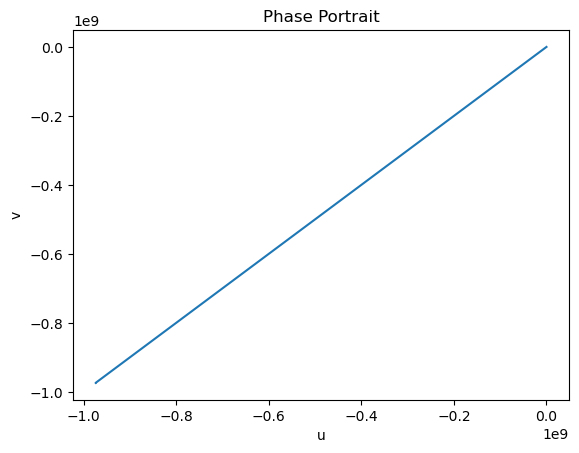

In [5]:
# 相図プロット
plt.plot(u, v)
plt.xlabel('u')
plt.ylabel('v')
plt.title('Phase Portrait')
plt.savefig("1SC22317Y05c03.pdf")
plt.show()

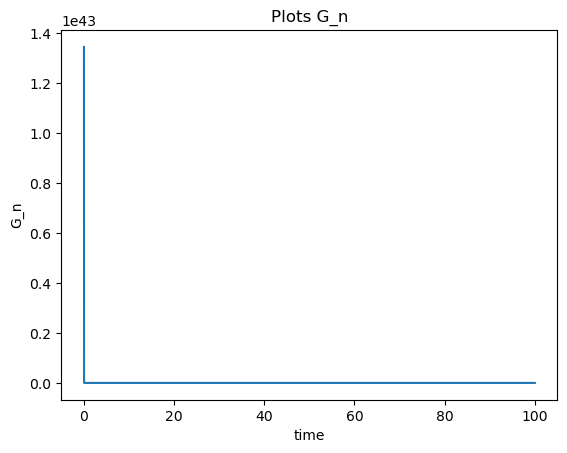

In [6]:
g_n=[gamma*np.exp(u[i])-delta*u[i]+beta*np.exp(v[i])-alpha*v[i] for i in range(n+1)]
plt.plot(np.linspace(t_start,t_end,n+1),g_n,label="G_n")
plt.xlabel("time")
plt.ylabel("G_n")
plt.title("Plots G_n")

plt.savefig("1SC22317Y05d01.pdf")
plt.show()
